# Problem 2: Extended Kalman Filter for Robot Localization

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

np.random.seed(123456)

## Simulation Setup

In [11]:
# Timesteps.
dt = 0.1
tf = 15
time = np.arange(0, tf+dt, dt)

# Ground-truth landmark positions.
xm = np.array([0, 0, 2, 8, 8, 2, 10, 10])
mr = len(xm) % 2

## Dynamics and Measurement Equations

In [12]:
def dynamics_model(
    xr: np.ndarray, 
    v: float, 
    omega: float,
) -> np.ndarray:
    """Kalman Filter dynamics model.

    NOTE: This dynamics model corresponds to Eq. (3) in the 
          homework PDF document.

    Args:
        xr (np.ndarray): Robot state.
        v (float): Linear velocity command.
        omega (float): Angular velocity command.

    Returns:
        np.ndarray: Next robot state.
    """
    return np.array([xr[0] + dt * v * np.cos(xr[2]),
                     xr[1] + dt * v * np.sin(xr[2]),
                     xr[2] + dt * omega])


def measurement_model(
    xr: np.ndarray, 
    xm: np.ndarray,
) -> np.ndarray:
    """Kalman Filter measurement model.
    
    NOTE: This measurement model corresponds to Eq. (4) in the
          homework PDF document.

    Args:
        xr (np.ndarray): Robot state.
        xm (np.ndarray): Landmark position.
    
    Returns:
        np.ndarray: Expected measurement.
    """
    px = xr[0]
    py = xr[1]
    th = xr[2]
    
    rot_mtx = np.array([[np.cos(th), np.sin(th)],
                        [-np.sin(th), np.cos(th)]])
    rot_mtx_tile = np.kron(np.eye(4, dtype=int),rot_mtx)
    robot_position_tile = np.tile(np.array([px, py]), (4,))

    return rot_mtx_tile @ (xm - robot_position_tile)


def getG(
    xr: np.ndarray, 
    v: float, 
    omega: float,
):
    """Computes the Jacobian of the dynamics model with respect 
    to the robot state and input commands.
    
    Args:
        xr (np.ndarray): Robot state.
        v (float): Linear velocity command.
        omega (float): Angular velocity command.
    
    Returns:
        G (np.ndarray): Jacobian of the dynamics model.
    """
    ####################### Code starts here #######################
    G = np.array([[1, 0, -v * dt * np.sin(xr[2])],
                  [0, 1, v * dt * np.cos(xr[2])],
                  [0, 0, 1]])
    ####################### Code ends here #######################
    return G


def getH(
    xr: np.ndarray, 
    xm: np.ndarray,
) -> np.ndarray:
    """Computes the Jacobian of the measurement model with respect
    to the robot state and the landmark positions.
    
    Args:
        xr (np.ndarray): Robot state.
        xm (np.ndarray): Landmark positions.
    
    Returns:
        H (np.ndarray): Jacobian of the measurement model.
    """
    ####################### Code starts here #######################
    px = xr[0]
    py = xr[1]
    th = xr[2]

    th_mtx = np.array([[-np.sin(th), np.cos(th)],
                        [-np.cos(th), -np.sin(th)]])
    th_mtx_tile = np.kron(np.eye(4, dtype=int),th_mtx)
    robot_position_tile = np.tile(np.array([px, py]), (4,))
    position_diff = xm - robot_position_tile
    H_right = th_mtx_tile @ position_diff
    
    rot_mtx = np.array([[np.cos(th), np.sin(th)],
                        [-np.sin(th), np.cos(th)]])
    rot_mtx_tile = np.tile(-rot_mtx, (4,1))
    H = np.hstack((rot_mtx_tile, H_right.reshape((8,1))))
    ####################### Code ends here #######################
    return H

## Extended Kalman Filter Setup

In [13]:
# Ground-truth states (simulated).
x = np.zeros((3, len(time)))
x[:, 0] = [1, 1, 0]

# Estimated states (Kalman Filter).
mu_ekf = np.zeros((3, len(time)))
cov_ekf = [np.eye(3) for _ in range(len(time))]

# Initial state and state covariance estimate.
init_mu_std = 0.1
mu_ekf[:, 0] = [1, 1, 0] + np.random.multivariate_normal(np.zeros((3,)), init_mu_std*np.eye(3))

# Process and observation noise.
Q = (dt**2 * 0.1) * np.eye(3)
R = 0.25 * np.eye(8)

# Extended Kalman Filter Implementation

In [14]:
for i in range(1, len(time)):
    ### Simulation.

    # True robot commands
    v = 1
    omega = np.sin(time[i])

    # True robot dynamics
    w_noise = np.random.multivariate_normal(np.zeros((3,)), Q)
    x[:, i] = dynamics_model(x[:, i-1], v, omega) + w_noise

    # True received measurement
    v_noise = np.random.multivariate_normal(np.zeros((8,)), R)
    y = measurement_model(x[:, i], xm) + v_noise

    ### Estimation.

    ####################### Code starts here #######################
    # NOTE: Implement Extended Kalman Filter Predict and Update steps. 
    # Write resulting means to mu_ekf.
    # Write resulting covariances to cov_ekf.

    # EKF Prediction
    mu_ekf[:, i] = dynamics_model(mu_ekf[:, i-1], v, omega)
    # Hint: Find current G (Jacobian of the state dynamics model)
    G = getG(mu_ekf[:, i], v, omega)
    cov_ekf[i] = G @ cov_ekf[i-1] @ G.T + Q

    # EKF Update
    # Hint: Find current H (Jacobian of the measurement model)
    H = getH(mu_ekf[:, i], xm)
    L = H @ cov_ekf[i] @ H.T + R
    K = cov_ekf[i] @ H.T @ np.linalg.inv(L)

    mu_ekf[:, i] = mu_ekf[:, i] + (K @ (y - measurement_model(mu_ekf[:, i], xm)))
    cov_ekf[i] = (np.eye(3) - K @ H) @ cov_ekf[i]
    ####################### Code ends here #######################

## Plot Results

In [15]:
def plot_error_ellipse(ax, mean, cov):
    # Calculate the error ellipse parameters
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    order = eigenvalues.argsort()[::-1]
    eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
    angle = np.degrees(np.arctan2(*eigenvectors[:,0][::-1]))
    
    # Compute the radius of the ellipse to correspond to the desired confidence level
    chi2_val = 2.4477  # Corresponds to 95% conf. interval
    width, height = 2 * chi2_val * np.sqrt(eigenvalues)
    
    # Draw the ellipse
    ellipse = patches.Ellipse(mean, width, height, angle, edgecolor='red', fc='None', lw=2)
    ax.add_patch(ellipse)

### Plot Mean Estimates of Robot Pose Trajectory

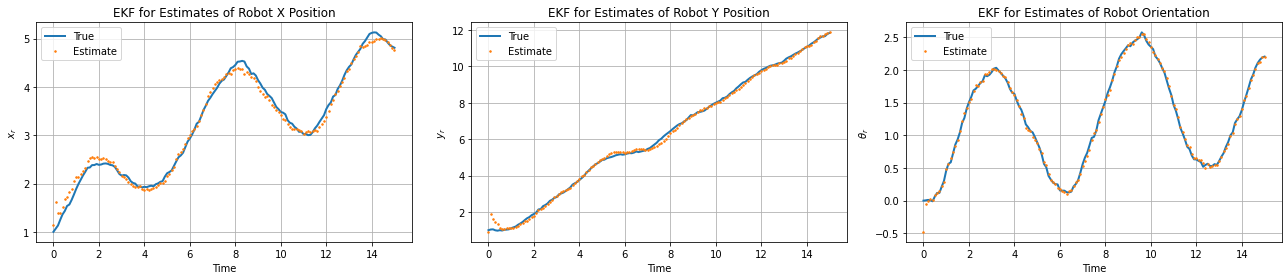

In [16]:
plt.figure(figsize=(18, 4))

# Subplot for px
plt.subplot(131)
plt.title('EKF for Estimates of Robot X Position')
plt.plot(time, x[0, :], linewidth=2, label='True')
plt.plot(time, mu_ekf[0, :], '.', markersize=3, label='Estimate')
plt.xlabel('Time')
plt.ylabel(r'$x_r$')
plt.legend()
plt.grid(True)

# Subplot for py
plt.subplot(132)
plt.title('EKF for Estimates of Robot Y Position')
plt.plot(time, x[1, :], linewidth=2, label='True')
plt.plot(time, mu_ekf[1, :], '.', markersize=3, label='Estimate')
plt.xlabel('Time')
plt.ylabel(r'$y_r$')
plt.legend()
plt.grid(True)


# Subplot for theta
plt.subplot(133)
plt.title('EKF for Estimates of Robot Orientation')
plt.plot(time, x[2, :], linewidth=2, label='True')
plt.plot(time, mu_ekf[2, :], '.', markersize=3, label='Estimate')
plt.xlabel('Time')
plt.ylabel(r'$\theta_r$')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Plot Error Ellipses Along Trajectory

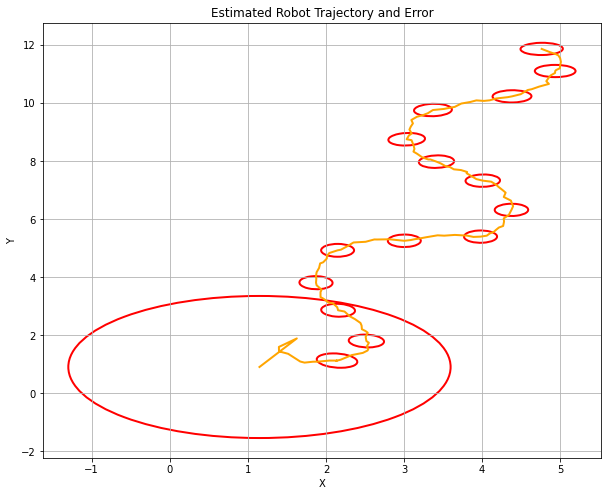

In [17]:
plt.figure(figsize=(10, 8))
plt.title('Estimated Robot Trajectory and Error')
plt.plot(mu_ekf[0, :], mu_ekf[1, :], color='orange', linewidth=2)
for i in range(0, len(time), 10):
    plot_error_ellipse(plt.gca(), mu_ekf[:2, i], cov_ekf[i][:2, :2])
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()

### Plot Robot Trajectory in X-Y Space

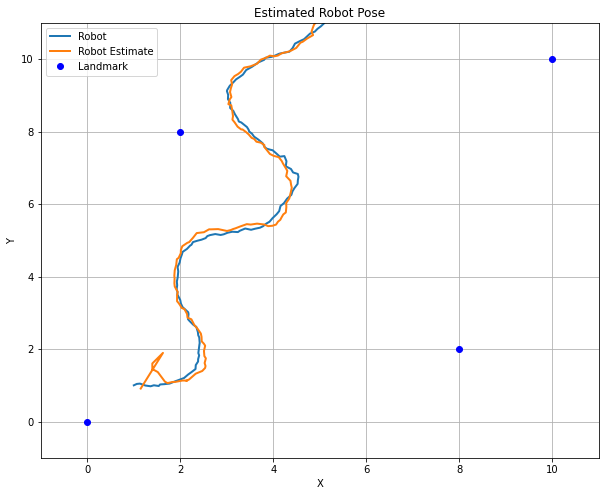

In [18]:
plt.figure(figsize=(10, 8))
plt.title('Estimated Robot Pose')
plt.plot(x[0, :], x[1, :], linewidth=2, label='Robot')
plt.plot(mu_ekf[0, :], mu_ekf[1, :], linewidth=2, label='Robot Estimate')
plt.plot(xm.reshape((4,2))[:, 0], xm.reshape((4,2))[:, 1], 'b.', markersize=12, label='Landmark')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.xlim([-1, 11])
plt.ylim([-1, 11])
plt.grid(True)
plt.show()